In [1]:
import matplotlib.pyplot as plt
import utils
import numerical_hysteresis
import synthetic
import torch
import numpy as np
from scipy.special import softmax

In [2]:
# Global parameters
n = 50
h,m = synthetic.generate_dataset(n)
x = torch.rand(int(n**2 / 2 + n / 2)).double()
x.requires_grad=True 

h_sat = 1.0
b_sat = 2.0

xx, yy=utils.generate_mesh(h_sat, n)

states=numerical_hysteresis.state(xx, yy, h_sat, h)

alpha = .50
num_iterations = 2000

In [3]:
# Loss function
def l(x, h, m, n):

    m_pred = numerical_hysteresis.discreteIntegral(xx, yy, h_sat, b_sat, x, 
                                                   h, n, states)
    loss = torch.sum((m_pred - m)**2)
    
    return loss

#print(x.shape)
#loss = l(x,h,m,n)
#loss.backward()


In [4]:
# Gradient descent implementation
def gradient_descent(Z0, function, alpha, n_iterations):
    """
    Performs 100 iterations of gradient descent
    
    Inputs:
    X0: a pytorch tensor to be modified in-place by the gradient descent algorithm
    function: a callable, that takes X0 as input
    alpha: step size for the gradient descent algorithm
    n_iterations: number of iterations of gradient descent
    
    Returns:
    history_Z: array of values of Z
    history_f: array of values of f
    """
    history_Z = []
    history_f = []
    for iteration in range(n_iterations): # iterations of gradient descent
        X0 = torch.nn.Softplus()(Z0)
        f = function(X0, h,m,n)
        
        f.backward()
        with torch.no_grad():
            Z0 -= alpha * Z0.grad
        
        Z0.grad.zero_()
        
        # Keep a copy in history 
        history_Z.append( Z0.detach().numpy().copy() ) 
        history_f.append( f.detach().numpy().copy() )
        
        # Tracks computational progress
#         if iteration % 500 == 0:
#             print(iteration)
        
    return np.array(history_Z), np.array(history_f)

0.060761876


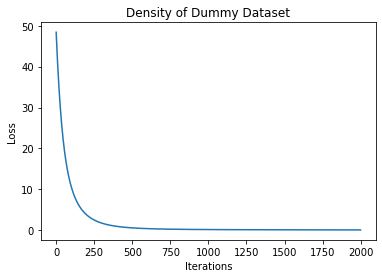

In [5]:
# Gradient descent execution

history_Z, history_f = gradient_descent( x, l, alpha, num_iterations)
z_star = torch.tensor(history_Z[-1]).double()
z_start = torch.tensor(history_Z[0]).double()
x_star = torch.nn.Softplus()(z_star)
x_start = torch.nn.Softplus()(z_start)
m_pred = numerical_hysteresis.discreteIntegral(xx, yy, h_sat, b_sat, x_star, h, n, states)
m_start = numerical_hysteresis.discreteIntegral(xx, yy, h_sat, b_sat, x_start, h, n, states)

# Plot the trajectory of the loss function
plt.plot(history_f)
plt.title('Density of Dummy Dataset')
plt.xlabel('Iterations')
plt.ylabel('Loss')

print(history_f[-1])

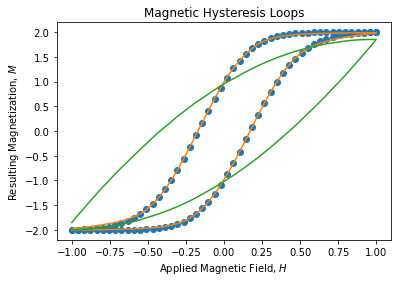

In [6]:
plt.plot(h, m, 'o')
plt.plot(h,m_pred)
plt.plot(h, m_start)
plt.title('Magnetic Hysteresis Loops')
plt.xlabel('Applied Magnetic Field, $H$')
plt.ylabel('Resulting Magnetization, $M$')
plt.show()

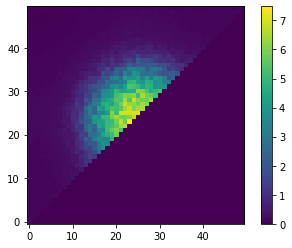

In [7]:
def plot_density(x, n):
    mat=utils.vector_to_tril(x, n)
    plt.imshow(mat, origin="lower")
    plt.colorbar()
    
plot_density(x_star,n)

In [9]:
# repeatability test

def compute_density():
    '''
    Calculates the optimum density, given a random intial density vector.
    This initial vector, x_test, is randomly generated each time that
    compute_density is called. 
    '''
    x_test = torch.rand(int(n**2 / 2 + n / 2)).double()
    x_test.requires_grad=True 
    history_Z, history_f = gradient_descent(x_test, l, alpha, num_iterations)
    x_star = torch.nn.Softplus()(torch.tensor(history_Z[-1]).double())
    return x_star

def run_trials(num_trials):
    trial_matrix = torch.empty(num_trials, (int(n**2 / 2 + n / 2)))
    for i in range(num_trials):
        trial_matrix[i] = compute_density()
        print(i)
    return trial_matrix

mtx = run_trials(15)

np.save("mtx.npy", mtx)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14


Max Standard Deviation: 0.561196506023407


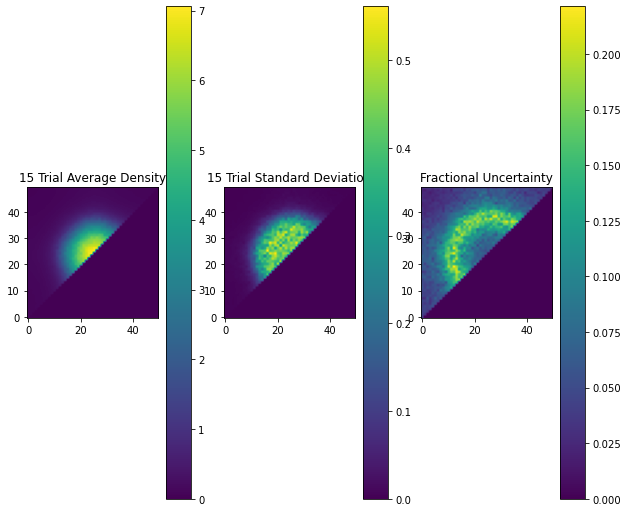

In [12]:
mtx = np.load("mtx.npy")

x_avg = mtx.mean(axis=0) 
x_sd = mtx.std(axis=0)

# plot density triangles side-by-side
plot_size = 10

fig_dens = plt.figure()
plt.subplot(1, 3, 1)
plot_density(torch.tensor(x_avg).double(), n)
fig_dens.set_figheight(plot_size)
fig_dens.set_figwidth(plot_size)
plt.title("15 Trial Average Density")

plt.subplot(1, 3, 2)
plot_density(torch.tensor(x_sd).double(),n)
fig_dens.set_figheight(plot_size)
fig_dens.set_figwidth(plot_size)
plt.title("15 Trial Standard Deviation")

plt.subplot(1, 3, 3)
plot_density((torch.tensor(x_sd/x_avg)).double(), n)
fig_dens.set_figheight(plot_size)
fig_dens.set_figwidth(plot_size)
plt.title("Fractional Uncertainty")

print(f"Max Standard Deviation: {max(x_sd)}")
# # scatter plot of standard deviation
# sd_plot = plt.figure(figsize = (9,9)) 
# plt.scatter(np.arange(int(n**2 / 2 + n / 2)), x_sd)
# plt.xlabel('Hysterion Index')
# plt.ylabel('Standard Deviation Over Trials')